# 11. Merge single-ended measurements into a double-ended datastore

Often people have set up a double ended cable to be measured as if it were two single ended setups, to prevent loss of data as some manufacturers throw out some raw data when doing double ended measurements. To do the double ended calibration the two channels have to be merged into a single datastore and aligned.

In [1]:
import os
from dtscalibration import read_silixa_files
from dtscalibration.datastore_utils import suggest_cable_shift_double_ended, shift_double_ended
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We load in both channels into seperate datastores

In [2]:
filepath_ch1 = os.path.join('..', '..', 'tests', 'data', 'double_single_ended', 'channel_1')
filepath_ch2 = os.path.join('..', '..', 'tests', 'data', 'double_single_ended', 'channel_2')

ds_ch1 = read_silixa_files(
    directory=filepath_ch1,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds_ch2 = read_silixa_files(
    directory=filepath_ch2,
    timezone_netcdf='UTC',
    file_ext='*.xml')

6 files were found, each representing a single timestep
4 recorded vars were found: LAF, ST, AST, TMP
Recorded at 8936 points along the cable
The measurement is single ended
Reading the data from disk
6 files were found, each representing a single timestep
4 recorded vars were found: LAF, ST, AST, TMP
Recorded at 8936 points along the cable
The measurement is single ended
Reading the data from disk


When plotting the data the two datasets already look quite similar as it is a duplex measurement.

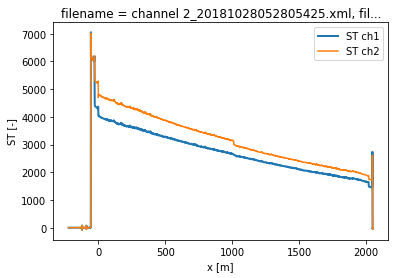

In [3]:
ds_ch1.isel(time=0).ST.plot(label='ST ch1', lw=2)
ds_ch2.isel(time=0).ST.plot(label='ST ch2')
plt.legend()

The second channel has to be flipped around to align the fibers correctly. To do this properly, a cable length has to be defined. This is the distance along the fiber between the connectors of channel 1 and channel 2.

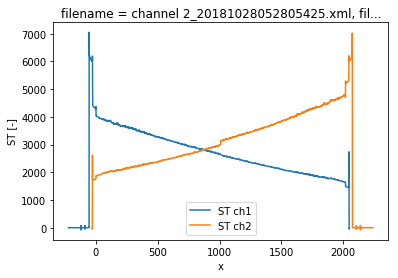

In [4]:
cable_length = 2017.7

ds_ch2['x'] = cable_length - ds_ch2.x.values
ds_ch2 = ds_ch2.sortby('x')

ds_ch1.isel(time=0).ST.plot(label='ST ch1')
ds_ch2.isel(time=0).ST.plot(label='ST ch2')
plt.legend()

Now the second channel has been reversed, we can merge the two channels. Make sure the two datasets are aligned time-wise and have the same amount of measurements in time. After merging some attributes have to be set to allow for double ended calibration

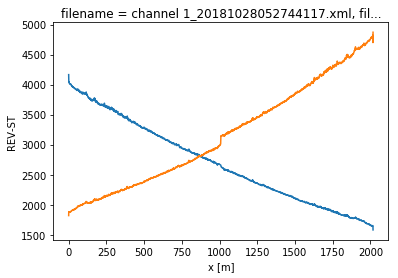

In [5]:
ds_ch1 = ds_ch1.sel(x=slice(0, cable_length))
ds_ch2 = ds_ch2.sel(x=slice(0, cable_length))

ds = ds_ch1

ds['REV-ST'] = (['x','time'], ds_ch2.ST.values)
ds['REV-AST'] = (['x','time'], ds_ch2.AST.values)

ds.attrs['isDoubleEnded'] = '1'
ds['userAcquisitionTimeBW'] = ('time', ds_ch2['userAcquisitionTimeFW'].values)

plt.figure()
ds['ST'].isel(time=0).plot()
ds['REV-ST'].isel(time=0).plot()

To perfectly align the two measurements we can use the alignment utility. It turns out we were off by 3 datapoints, so let's shift it by that.

I dont know what to do with the following data ['TMP']
I dont know what to do with the following data ['TMP']
I dont know what to do with the following data ['TMP']


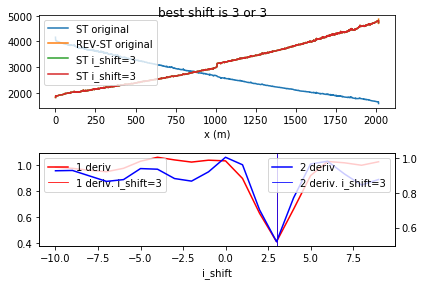

In [6]:
shift1, shift2 = suggest_cable_shift_double_ended(ds.isel(time=[0,-1]).compute(),
                                                  np.arange(-10, 10, 1, dtype=int))

ds = shift_double_ended(ds, shift1)

Now we can calibrate the data double ended as usual.